In [46]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import poisson

In [47]:
path = "~/Documents/spatial_clustering/final_project/data/"

In [48]:
census_df = gpd.read_file(
    path + "census_tracts/geo_export_a19e0577-c0ec-456a-8bea-703d57c3459d.shp"
)
census_df.head()

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,geometry
0,44,44.0,031,17031842400,8424,Census Tract 8424,None,17,842400,"POLYGON ((-87.62405 41.73022, -87.62405 41.730..."
1,59,59.0,031,17031840300,8403,Census Tract 8403,None,17,840300,"POLYGON ((-87.68608 41.82296, -87.68607 41.823..."
2,34,34.0,031,17031841100,8411,Census Tract 8411,None,17,841100,"POLYGON ((-87.62935 41.85280, -87.62934 41.852..."
3,31,31.0,031,17031841200,8412,Census Tract 8412,None,17,841200,"POLYGON ((-87.68813 41.85569, -87.68816 41.856..."
4,32,32.0,031,17031839000,8390,Census Tract 8390,None,17,839000,"POLYGON ((-87.63312 41.87449, -87.63306 41.874..."


In [49]:
schedule_df = pd.read_csv(path+'google_transit/stop_times.txt')

schedule_df

,trip_id,arrival_time,departure_time,stop_id,stop_sequence,stop_headsign,pickup_type,shape_dist_traveled
0,82248584890,05:43:30,05:43:30,30205,6,Loop,0,34873
1,82248584890,05:46:00,05:46:00,30215,7,Loop,0,40317
2,81248584890,05:46:00,05:46:00,30215,7,Loop,0,40317
3,82248584890,05:51:00,05:51:00,30080,8,Loop,0,51245
4,81248584890,05:51:00,05:51:00,30080,8,Loop,0,51245
...,...,...,...,...,...,...,...,...
2663178,6620044930010,19:36:15,19:36:15,2082,38,Austin,0,26826
2663179,6620044930010,19:37:00,19:37:00,2083,39,Austin,0,27493
2663180,6620044930010,19:37:29,19:37:29,2084,40,Austin,0,28161
2663181,6620044930010,19:38:04,19:38:04,17979,41,Austin,0,28965


In [50]:
bus_point_df = gpd.read_file(
    path + "CTA_BusStops/CTA_BusStops.shp"
)

In [51]:
bus_point_df['SYSTEMSTOP'] = bus_point_df['SYSTEMSTOP'].astype(int)
bus_point_df.head(5)

,SYSTEMSTOP,STREET,CROSS_ST,DIR,POS,ROUTESSTPG,OWLROUTES,CITY,PUBLIC_NAM,geometry
0,5282,JEFFERY,97TH STREET,NB,MT,15,None,CHICAGO,Jeffery & 97th Street,POINT (-87.57521 41.71888)
1,1143,STOCKTON,WEBSTER,NB,NT,"151,156",None,CHICAGO,Stockton & Webster,POINT (-87.63563 41.92192)
2,15703,HARLEM,SCHNEIDER,NB,NS,90,None,OAK PARK,Harlem & Schneider,POINT (-87.80512 41.89619)
3,6501,WENTWORTH,3200 SOUTH,SB,MB,"24,31",None,CHICAGO,3200 S Wentworth,POINT (-87.63168 41.83648)
4,1593,MICHIGAN,14TH STREET,SB,FS,"1,3,4",N4,CHICAGO,Michigan & 14th Street,POINT (-87.62419 41.86388)


In [52]:
stop_counts = schedule_df.groupby('stop_id').size().reset_index(name='stop_count')
stop_counts

,stop_id,stop_count
0,1,338
1,2,170
2,4,170
3,6,170
4,7,170
...,...,...
11004,30382,580
11005,30383,1200
11006,30384,1854
11007,30385,82


In [53]:
bus_df_2 = bus_point_df.copy()
bus_df_2 = pd.merge(bus_df_2, stop_counts, how='inner', left_on='SYSTEMSTOP', right_on='stop_id')
bus_df_2.head()

,SYSTEMSTOP,STREET,CROSS_ST,DIR,POS,ROUTESSTPG,OWLROUTES,CITY,PUBLIC_NAM,geometry,stop_id,stop_count
0,5282,JEFFERY,97TH STREET,NB,MT,15,None,CHICAGO,Jeffery & 97th Street,POINT (-87.57521 41.71888),5282,384
1,1143,STOCKTON,WEBSTER,NB,NT,"151,156",None,CHICAGO,Stockton & Webster,POINT (-87.63563 41.92192),1143,300
2,15703,HARLEM,SCHNEIDER,NB,NS,90,None,OAK PARK,Harlem & Schneider,POINT (-87.80512 41.89619),15703,157
3,6501,WENTWORTH,3200 SOUTH,SB,MB,"24,31",None,CHICAGO,3200 S Wentworth,POINT (-87.63168 41.83648),6501,62
4,1593,MICHIGAN,14TH STREET,SB,FS,"1,3,4",N4,CHICAGO,Michigan & 14th Street,POINT (-87.62419 41.86388),1593,606


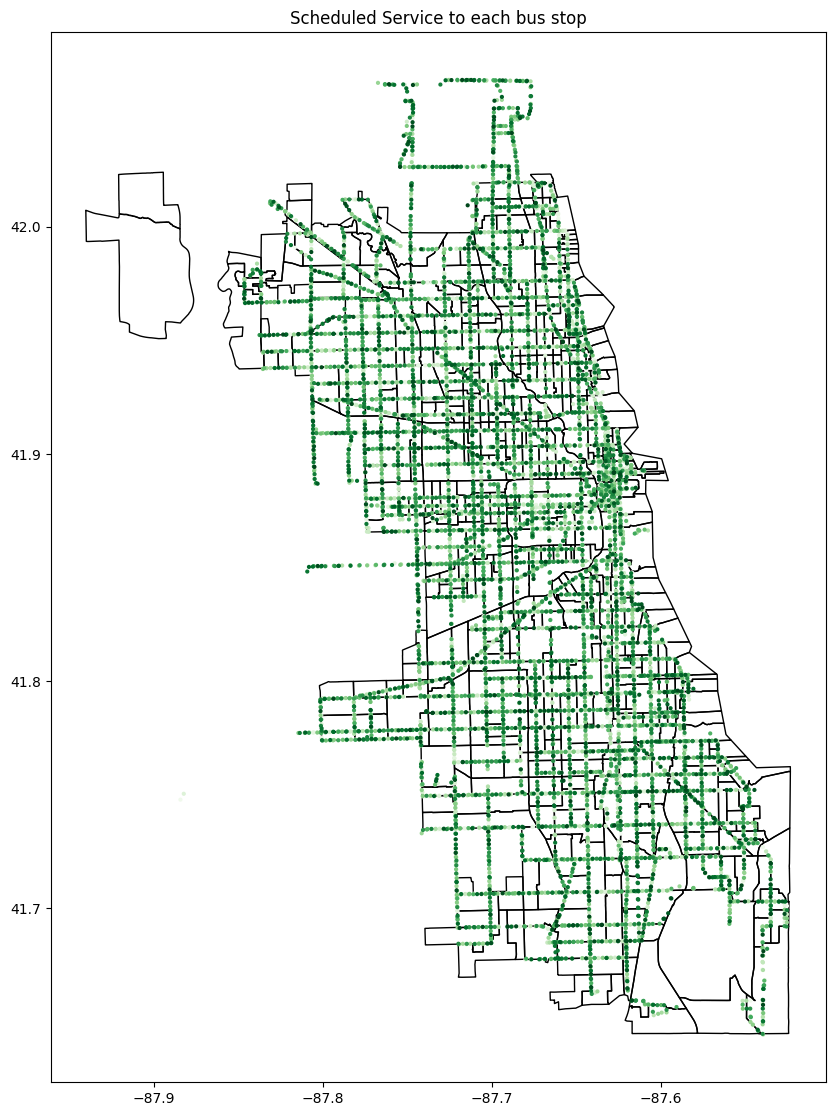

In [32]:
census_df = census_df.to_crs(bus_df_2.crs)
fig, ax = plt.subplots(figsize=(10, 15))
census_df.plot(ax=ax, color="none", edgecolor="black")
bus_df_2.plot(ax=ax, markersize=4, 
                    c=bus_df_2.stop_count, 
                    cmap="Greens", marker='o', legend=True,
                    legend_kwds={'loc': 'upper right'})
plt.title('Scheduled Service to each bus stop')
# plt.savefig("../figures/scheduled_bus_stops.png")
plt.show()

In [55]:
# census_df = census_df.to_crs(bus_df_2.crs)

# bus_df_2 = bus_df_2.to_crs(census_df.crs)
# bus_df_2

stops_census = gpd.sjoin(bus_df_2, census_df, how="left", op="intersects")

type(stops_census)

/Users/meganmoore/miniconda3/envs/transit_clustering/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):
/var/folders/d4/vbphhpzx0_585fnvq9gjq5z00000gn/T/ipykernel_1856/94830805.py:6: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...

  stops_census = gpd.sjoin(bus_df_2, census_df, how="left", op="intersects")


geopandas.geodataframe.GeoDataFrame

In [12]:
point_sum = stops_census.groupby("geoid10")['stop_count'].sum().reset_index(name="count")
point_sum

,geoid10,count
0,17031010100,250
1,17031010201,597
2,17031010202,3834
3,17031010300,3297
4,17031010400,3561
...,...,...
791,17031843600,3141
792,17031843700,5760
793,17031843800,4324
794,17031843900,14757


In [96]:
prob_census_df = census_df.merge(point_sum, how="left", on="geoid10").fillna(0)
prob_census_df

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,geometry,count
0,44,44.0,031,17031842400,8424,Census Tract 8424,0,17,842400,"POLYGON ((-87.62405 41.73022, -87.62405 41.730...",8867.0
1,59,59.0,031,17031840300,8403,Census Tract 8403,0,17,840300,"POLYGON ((-87.68608 41.82296, -87.68607 41.823...",5450.0
2,34,34.0,031,17031841100,8411,Census Tract 8411,0,17,841100,"POLYGON ((-87.62935 41.85280, -87.62934 41.852...",5310.0
3,31,31.0,031,17031841200,8412,Census Tract 8412,0,17,841200,"POLYGON ((-87.68813 41.85569, -87.68816 41.856...",3302.0
4,32,32.0,031,17031839000,8390,Census Tract 8390,0,17,839000,"POLYGON ((-87.63312 41.87449, -87.63306 41.874...",5138.0
...,...,...,...,...,...,...,...,...,...,...,...
796,7,7.0,031,17031070400,704,Census Tract 704,0,17,070400,"POLYGON ((-87.65746 41.93258, -87.65722 41.932...",866.0
797,7,7.0,031,17031070500,705,Census Tract 705,0,17,070500,"POLYGON ((-87.66349 41.93036, -87.66350 41.930...",619.0
798,13,13.0,031,17031130300,1303,Census Tract 1303,0,17,130300,"POLYGON ((-87.71436 41.98300, -87.71472 41.982...",2496.0
799,29,29.0,031,17031292200,2922,Census Tract 2922,0,17,292200,"POLYGON ((-87.71317 41.85523, -87.71357 41.855...",1669.0


In [101]:
# prob_census_df.loc[:, 'count'].max()
prob_census_df.loc[prob_census_df.loc[:, 'count'] == 28934, :]

,commarea,commarea_n,countyfp10,geoid10,name10,namelsad10,notes,statefp10,tractce10,geometry,count
96,32,32.0,031,17031839100,8391,Census Tract 8391,0,17,839100,"POLYGON ((-87.63581 41.88738, -87.63544 41.887...",28934.0


In [95]:
prob_census_df=prob_census_df['co']
prob_census_df.geometry.area/10**6

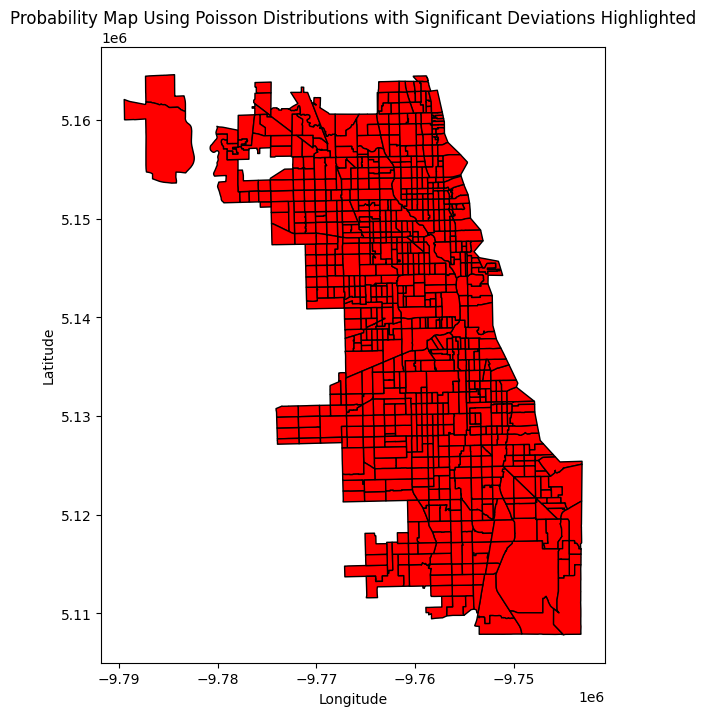

In [94]:
prob_census_df=prob_census_df.to_crs(3857)
prob_census_df['area'] = prob_census_df.geometry.area / 10**6
avg_intensity = prob_census_df['count'].sum() / prob_census_df['area'].sum()
prob_census_df['expected_rate'] = avg_intensity * prob_census_df['area']

# Compute the probability of observing the actual number of bus stops given the expected rate
prob_census_df['poisson_prob'] = poisson.pmf(prob_census_df['count'], prob_census_df['expected_rate'])

# Define significant deviations based on a threshold (e.g., p-value < 0.05)
significant_deviation = prob_census_df['poisson_prob'] < 0.05

# Plot the probability map
fig, ax = plt.subplots(figsize=(10, 8))
prob_census_df.plot(column='poisson_prob', cmap='coolwarm', ax=ax)

# Highlight significant deviations
# prob_census_df[significant_deviation].plot(ax=ax, color='red', edgecolor='black', alpha=1)

plt.title('Probability Map Using Poisson Distributions')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.savefig("../figures/pooissonn_probability_map.png")
plt.show()

/var/folders/d4/vbphhpzx0_585fnvq9gjq5z00000gn/T/ipykernel_1856/3813840755.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  prob_census_df["area"] = prob_census_df.geometry.area / 10**6


Average Intensity: 34244199049320.35


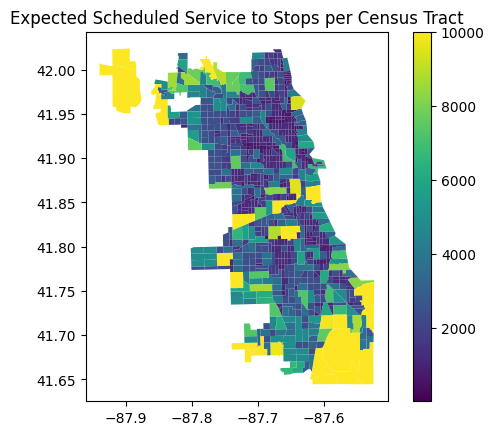

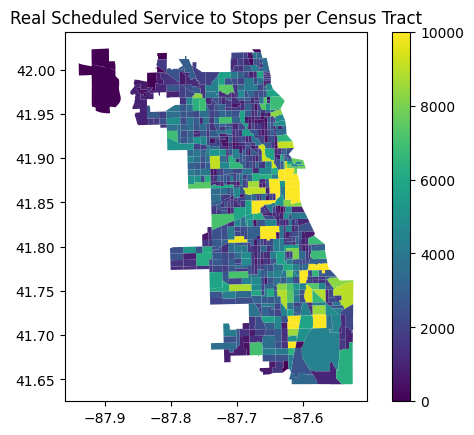

In [106]:
# Area calculations
prob_census_df["area"] = prob_census_df.geometry.area / 10**6

# Average Intensity
avg_intensity = prob_census_df["count"].sum() / prob_census_df["area"].sum()
print("Average Intensity:", avg_intensity)

# Expected number of points in each area
prob_census_df["exppts"] = avg_intensity * prob_census_df["area"]

fig, ax = plt.subplots()
prob_census_df[["exppts", "geometry"]].plot("exppts", ax=ax,legend=True, vmax=10000)
plt.title('Expected Scheduled Service to Stops per Census Tract')
plt.savefig("../figures/expected_service_rates.png")
plt.show()

fig, ax = plt.subplots()
prob_census_df[["count", "geometry"]].plot("count", ax=ax,legend=True, vmax=10000)
plt.title('Real Scheduled Service to Stops per Census Tract')
plt.savefig("../figures/real_service_rates.png")
plt.show()

prob_census_df["ptprob"] = poisson.pmf(
    prob_census_df["count"], prob_census_df["exppts"])


conditions = [
    (prob_census_df["count"] > prob_census_df["exppts"])
    & (prob_census_df["ptprob"] < 0.05),
    (prob_census_df["count"] < prob_census_df["exppts"])
    & (prob_census_df["ptprob"] < 0.05),
]

prob_census_df["prob_map"] = np.select(
    conditions,
    ["More than expected", "Less than expected"],
    default="Non-significant",
)


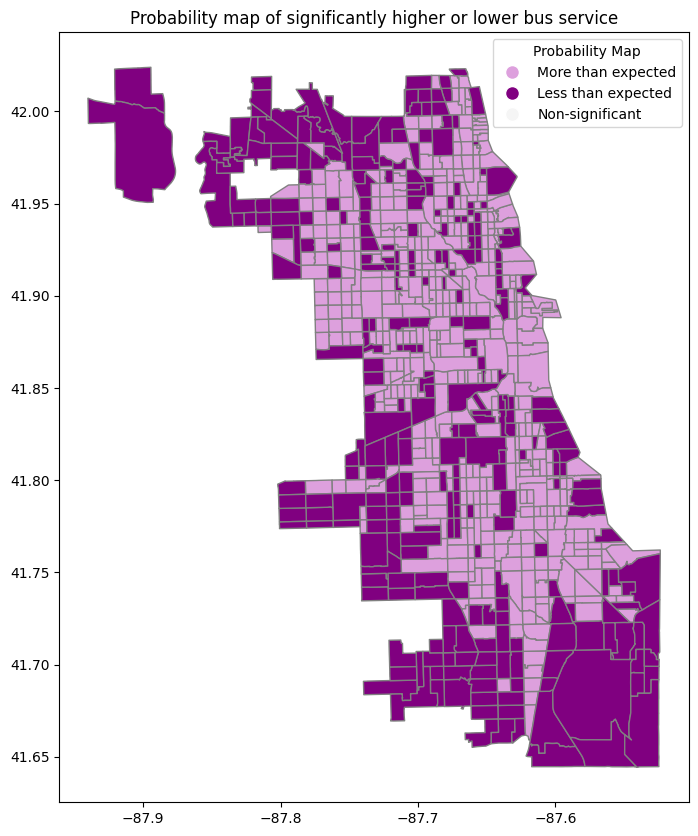

In [103]:

category_colors = {
    "More than expected": "plum",
    "Less than expected": "purple",
    "Non-significant": "whitesmoke",
}
fig, ax = plt.subplots(figsize=(20, 10))

for category, color in category_colors.items():
    if category in list(prob_census_df["prob_map"].unique()):
        prob_census_df[prob_census_df["prob_map"] == category].plot(
            ax=ax, color=color, label=category, edgecolor="grey"
        )

# bus_point_df.plot(ax=ax, color='red', markersize=0.5)

# Create a custom legend
handles = [
    plt.Line2D(
        [0], [0], marker="o", color="w", markerfacecolor=color, markersize=10
    )
    for color in category_colors.values()
]
labels = category_colors.keys()
ax.legend(handles, labels, title="Probability Map", loc="upper right")
plt.title('Probability map of significantly higher or lower bus service')
# plt.savefig("../figures/true_scheduled_bus_density.png")
plt.show()

In [16]:
import pygeoda

In [17]:
print(bus_df_2.crs)
census_bus_crs_df = census_df.to_crs(bus_df_2.crs)

EPSG:4326


In [18]:

stops_census_df = gpd.sjoin(bus_df_2, census_bus_crs_df, how="inner", op="intersects")
point_sum_df = stops_census_df.groupby("geoid10")['stop_count'].sum().reset_index(name="count")
point_sum_df['count'] = point_sum_df['count'].astype(float)
point_sum_gdf = gpd.GeoDataFrame(point_sum_df, geometry=gpd.GeoSeries(census_bus_crs_df['geometry']))

/Users/meganmoore/miniconda3/envs/transit_clustering/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [30]:
point_sum_gdf['count'].min()

110.0

In [20]:
geom_stops_df = point_sum_gdf.merge(census_bus_crs_df, on='geoid10')

In [28]:
geom_stops_df['count'].min()

110.0

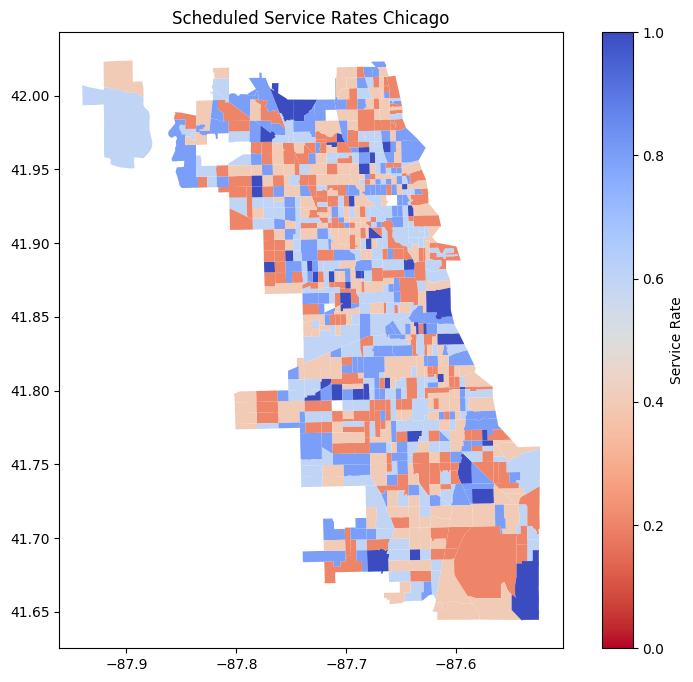

In [45]:
breaks15 = pygeoda.hinge15_breaks(point_sum_gdf['count'])


fig, ax = plt.subplots(figsize=(10, 8))
point_sum_gdf.plot(column='count', cmap='coolwarm_r', ax=ax, scheme='User_Defined', classification_kwds={'bins': breaks15})
# Add a colorbar
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap='coolwarm_r'), ax=ax)
cbar.set_label('Service Rate')
plt.title('Scheduled Service Rates Chicago')
plt.savefig("../figures/true_scheduled_bus_density_fromhinges.png")
plt.show()

In [23]:
breaks15

(-1848.25, 1443.5, 2318.0, 3638.0, 6929.75)